## read datasets

In [1]:
import pandas as pd
import random
from prepare_data import preprocess_data_czech
from eval import comapre_unidist_cont, compute_ngram_metrics, comapre_unidist_cat, compute_2d_categorical_metrics
import datetime
import calendar
import numpy as np
pd.set_option('display.max_rows', 100)

2024-02-16 22:51:13.523572: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


ModuleNotFoundError: No module named 'nltk'

In [2]:
from myctgan import CTGAN
from data_transformer import DataTransformer
from data_sampler import DataSampler
from train import Train
import numpy as np
import tensorflow as tf
import pandas as pd
import json
import pickle
import datetime
import calendar
from scipy.stats import norm
import os
import random

from prepare_data import preprocess_data_czech

def process_group(group):
    n = 80
    chunks = [group.iloc[i:i + n] for i in range(0, len(group), n)]
    processed_chunks = [chunk for chunk in chunks if len(chunk) == n]
    return processed_chunks

with tf.device('/gpu:1'):
    df = pd.read_csv('../DATA/tr_by_acct_w_age.csv')
    print('preprocessing data....')
    raw_data, LOG_AMOUNT_SCALE, TD_SCALE = preprocess_data_czech(df)
    raw = raw_data.copy()

    final_raw = raw[['log_amount_sc', 'tcode', 'td', 'day', 'dow', 'dtme', 'month']]
    #final_raw = raw[['log_amount_sc', 'tcode', 'td']]

    # Process each group
    processed_groups = raw.groupby('account_id').apply(process_group)

    # Flatten the list of DataFrames and assign new account IDs
    new_account_id = 0
    processed_dfs = []
    for group in processed_groups:
        for chunk in group:
            chunk['new_account_id'] = new_account_id
            processed_dfs.append(chunk)
            new_account_id += 1

    # Concatenate all processed DataFrames
    final_df = pd.concat(processed_dfs, ignore_index=True)



    synth_bf = pd.read_csv('../Banksformer/synth_tcode.csv')
    grouped = synth_bf.groupby('account_id')
    #grouped = final_df.groupby('new_account_id')



    print('transforming data...')
    transformer = DataTransformer(date_transformation='clock')
    #transformer = DataTransformer(date_transformation='clock')

    transformer.fit(final_raw, discrete_columns=('tcode'), date_columns= ('day', 'dow', 'dtme', 'month'))     
    data_t   = transformer.transform(final_raw)                #matrix of transformed data
    output_info = transformer.output_info_list

    account_id_counts = raw_data['account_id'].value_counts().sort_index()
    trans_sizes = np.array(account_id_counts)
    assert sum(trans_sizes) == data_t.shape[0]
    transactions = np.split(data_t, np.cumsum(trans_sizes)[:-1])   #transactions is the list of arrays, each array is for an individual customer 


    log_frequency = True
    sampler = DataSampler(data_t, transactions, output_info, log_frequency)


    with open('transformerobject_clock.pkl', 'wb') as file:
        pickle.dump(transformer, file)

    with open('samplerobject_clock.pkl', 'wb') as file:
        pickle.dump(sampler, file)

    model = CTGAN()
    generator  = model.make_generator(sampler, transformer)
    discriminator = model.make_discriminator(sampler, transformer)




(CVXPY) Feb 16 10:51:25 PM: Encountered unexpected exception importing solver SCS:
ImportError('libmkl_rt.so.2: cannot open shared object file: No such file or directory')


2024-02-16 22:51:25.670051: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-16 22:51:25.670881: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-02-16 22:51:25.700037: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2024-02-16 22:51:25.700292: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2024-02-16 22:51:25.700314: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-02-16 22:5

preprocessing data....
transforming data...


/users/fs2/hmehri/miniconda3/envs/tddpm/lib/python3.9/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/users/fs2/hmehri/miniconda3/envs/tddpm/lib/python3.9/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


In [3]:
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 116)]             0         
_________________________________________________________________
residual_layer (ResidualLaye (None, 372)               30976     
_________________________________________________________________
residual_layer_1 (ResidualLa (None, 500)               48256     
_________________________________________________________________
dense (Dense)                (None, 44)                22044     
Total params: 101,276
Trainable params: 100,508
Non-trainable params: 768
_________________________________________________________________


In [4]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 600)]             0         
_________________________________________________________________
discriminator_layer (Discrim (None, 128)               76928     
_________________________________________________________________
discriminator_layer_1 (Discr (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 110,209
Trainable params: 110,209
Non-trainable params: 0
_________________________________________________________________


: 

In [3]:
#dataset is downloaded from https://github.com/BigTuna08/Banksformer_ecml_2022/tree/4e998944825f04f94f6cb3a0058b4733fd70ccf5/czech/banksformer/data
real = pd.read_csv('../DATA/tr_by_acct_w_age.csv')
real = real.sort_values(by = ["account_id", "date"])
real, _, _ = preprocess_data_czech(real)
real_cf = real[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
real_sorted = real.sort_values(['account_id', 'year', 'month', 'day'])
real['td_new'] = real['td']

In [4]:
real

,Unnamed: 0,column_a,account_id,date,type,operation,amount,balance,k_symbol,age,...,doy,td,dtme,raw_amount,DoM_cat,age_group,log_amount,log_amount_sc,td_sc,td_new
0,0,149432,1,950324,CREDIT,CREDIT IN CASH,1000.0,1000.0,NaN,29,...,83,0.0,7,1000.0,last,18-30,3.000434,2.823750,0.000000,0.0
1,1,157404,1,950413,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,4679.0,NaN,29,...,103,20.0,17,3679.0,middle,18-30,3.565848,3.355869,3.298201,20.0
2,2,158832,1,950423,CREDIT,CREDIT IN CASH,12600.0,17279.0,NaN,29,...,113,10.0,7,12600.0,last,18-30,4.100405,3.858949,1.649100,10.0
3,3,162681,1,950430,CREDIT,NaN,19.2,17298.2,INTEREST CREDITED,29,...,120,7.0,0,19.2,last,18-30,1.305351,1.228484,1.154370,7.0
4,4,167083,1,950513,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,20977.2,NaN,29,...,133,13.0,18,3679.0,middle,18-30,3.565848,3.355869,2.143831,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056315,1056315,1033141,11382,981202,DEBIT,CASH WITHDRAWAL,25600.0,41114.4,NaN,46,...,336,2.0,29,-25600.0,first,41-50,4.408257,4.148672,0.329820,2.0
1056316,1056316,1040574,11382,981210,CREDIT,COLLECTION FROM ANOTHER BANK,46248.0,87362.4,NaN,46,...,344,8.0,21,46248.0,first,41-50,4.665102,4.390393,1.319280,8.0
1056317,1056317,1050362,11382,981225,DEBIT,CASH WITHDRAWAL,6300.0,81062.4,NaN,46,...,359,15.0,6,-6300.0,last,41-50,3.799409,3.575677,2.473651,15.0
1056318,1056318,1053037,11382,981231,CREDIT,NaN,311.3,81373.6,INTEREST CREDITED,46,...,365,6.0,0,311.3,last,41-50,2.494572,2.347677,0.989460,6.0


In [23]:
synth = pd.read_csv('../DATA/synth_ctgan_type1_clock_trans_dp1.csv')
synth['date'] = pd.to_datetime(synth['date'])

# Extract year, month, and day into separate columns
synth['year'] = synth['date'].dt.year
synth['month'] = synth['date'].dt.month
synth['day'] = synth['date'].dt.day

synth['type'] = synth['tcode'].str.split('__').str[0]
synth['amount'] = synth['log_amount_sc']
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])

synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

synth["td_new"] = synth[["account_id", "date"]].groupby("account_id").diff()
synth["td_new"] = synth["td_new"].apply(lambda x: x.days)
synth["td_new"].fillna(0.0, inplace=True)

synth['td'] = synth['td_new']


In [24]:
# Wasserstein-1 distances for univariate amount (Amt) and Cash Flow
# the column names of continous features
CONT_FIELDS = ["amount", "td"]

CF_FIELD = 'raw_amount'

#compare univariate distribution of continuous columns
comapre_unidist_cont(CONT_FIELDS,CF_FIELD, real, synth, real_cf, synth_cf)

{'amount': {'wasser': 2033.007046369835,
  'ks': 0.1380569842471978,
  'energy_d': 17.077668330465695},
 'td': {'wasser': 0.7957904225992124,
  'ks': 0.07994808770069678,
  'energy_d': 0.28376918352685576},
 'CF': {'wasser': 6703.754371910572,
  'ks': 0.33931325840282234,
  'energy_d': 49.608296098772456}}

In [20]:
# JSD between the distributions of tcode 3-grams
combo_df, result = compute_ngram_metrics(real_sorted, synth_sorted, 'tcode', 3)
result

{'jsd': 0.24609319488205827,
 'entr_r': 5.425261658301509,
 'entr_g': 5.659141614232967,
 'NED': -0.2338799559314575,
 'l1': 1.0068748293324012,
 'l2': 0.06698447654287296,
 'jac': 0.5591444783937145,
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 1870,
 'coverage_g': 0.45654296875,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [21]:
# JSD result comparing the univariate distributions of the tcode (Tcode), and DOM
CAT_FIELDS = ['tcode', 'day', 'month']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real, synth, field)
result_jst_cat

{'tcode': 0.08938603576321606,
 'day': 0.060360837694155484,
 'month': 0.002412221911614946}

In [22]:
#joint distribution of two categorical columns(tcode, DOM)
field1 = 'tcode'
field2 = 'day'
compute_2d_categorical_metrics(real, synth, field1, field2)

{'jsd': 0.2395602800102103,
 'entr_r': 4.314351501994391,
 'entr_g': 5.163077189781114,
 'l1': 0.988512870342321,
 'l2': 0.12676039558237354,
 'jac': 0.5717171717171717,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 467.0,
 'coverage_g': 0.9415322580645161,
 'count_max': 496}

In [3]:
raw_data, LOG_AMOUNT_SCALE, TD_SCALE = preprocess_data_czech(real)

In [1]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
n = 1056320
batch_size = 700
noise_multiplier = 2.2
epochs = 100
delta = 1e-5
epsilon, _ = compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=n, batch_size=batch_size,noise_multiplier=noise_multiplier,epochs=epochs,delta=delta)
epsilon


2024-02-14 12:19:33.048498: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


DP-SGD with sampling rate = 0.0663% and noise_multiplier = 2.2 iterated over 150903 steps satisfies differential privacy with eps = 0.601 and delta = 1e-05.
The optimal RDP order is 40.0.


0.6012868827149158

In [5]:
raw_data['date'] = pd.to_datetime(raw_data['date'])
df = raw_data[['account_id', 'tcode', 'datetime', 'amount']]
df

,account_id,tcode,datetime,amount
0,1,CREDIT__CREDIT IN CASH__nan,1995-03-24,1000.0
1,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-04-13,3679.0
2,1,CREDIT__CREDIT IN CASH__nan,1995-04-23,12600.0
3,1,CREDIT__nan__INTEREST CREDITED,1995-04-30,19.2
4,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-05-13,3679.0
...,...,...,...,...
1056315,11382,DEBIT__CASH WITHDRAWAL__nan,1998-12-02,25600.0
1056316,11382,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1998-12-10,46248.0
1056317,11382,DEBIT__CASH WITHDRAWAL__nan,1998-12-25,6300.0
1056318,11382,CREDIT__nan__INTEREST CREDITED,1998-12-31,311.3


* non-recurring : 'DEBIT__CASH WITHDRAWAL__ ', DEBIT__CASH WITHDRAWAL__nan, 'DEBIT__CASH WITHDRAWAL__HOUSEHOLD', 'DEBIT__CASH WITHDRAWAL__SANCTION INTEREST',  'DEBIT__CREDIT CARD WITHDRAWAL__nan',  'DEBIT__CASH WITHDRAWAL__INSURANCE PAYMENT', 'CREDIT__CREDIT IN CASH__nan'

* recurring : 'DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT', 'CREDIT__nan__INTEREST CREDITED', 'DEBIT__REMITTANCE TO ANOTHER BANK__nan', 'DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD',  'CREDIT__COLLECTION FROM ANOTHER BANK__nan', 'DEBIT__REMITTANCE TO ANOTHER BANK__ ', 'DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE PAYMENT', 'DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT',  'CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE PENSION'

In [6]:
recurring_tcodes = ['DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT', 'CREDIT__nan__INTEREST CREDITED', 'DEBIT__REMITTANCE TO ANOTHER BANK__nan', 
                    'DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD',  'CREDIT__COLLECTION FROM ANOTHER BANK__nan', 'DEBIT__REMITTANCE TO ANOTHER BANK__ ', 
                    'DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE PAYMENT', 'DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT', 
                     'CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE PENSION']

## Type1_lstm

In [43]:
synth = pd.read_csv('../Banksformer/synth_banksformer_type2_v2.csv')
synth

,amount,tcode,td,account_id,cumulative_td,datetime
0,81.37,DEBIT__REMITTANCE TO ANOTHER BANK__,0,0,0,1997-03-29
1,349.65,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,5,0,5,1997-04-03
2,790.38,CREDIT__CREDIT IN CASH__nan,4,0,9,1997-04-07
3,2.02,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,14,0,23,1997-04-21
4,26.16,CREDIT__nan__INTEREST CREDITED,0,0,23,1997-04-21
...,...,...,...,...,...,...
399995,984.22,DEBIT__REMITTANCE TO ANOTHER BANK__nan,5,4999,470,1994-11-18
399996,3682.59,CREDIT__COLLECTION FROM ANOTHER BANK__nan,4,4999,474,1994-11-22
399997,1136.54,DEBIT__REMITTANCE TO ANOTHER BANK__nan,5,4999,479,1994-11-27
399998,1290.66,DEBIT__CASH WITHDRAWAL__nan,8,4999,487,1994-12-05


In [44]:
# Extract year, month, and day into separate columns
synth['date'] = pd.to_datetime(synth['datetime'])
synth['year'] = synth['date'].dt.year
synth['month'] = synth['date'].dt.month
synth['day'] = synth['date'].dt.day
#synth['amount'] = synth['log_amount_sc']
synth['type'] = synth['tcode'].str.split('__').str[0]
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])

synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()




In [45]:
# Wasserstein-1 distances for univariate amount (Amt) and Cash Flow
# the column names of continous features
CONT_FIELDS = ["amount", "td"]

CF_FIELD = 'raw_amount'

#compare univariate distribution of continuous columns
comapre_unidist_cont(CONT_FIELDS,CF_FIELD, real, synth, real_cf, synth_cf)

{'amount': {'wasser': 4931.167326711869,
  'ks': 0.3832800302938504,
  'energy_d': 44.3306559134624},
 'td': {'wasser': 1.3215464192668893,
  'ks': 0.17418808770069677,
  'energy_d': 0.4983499043367147},
 'CF': {'wasser': 5015.316270309661,
  'ks': 0.18763561391281228,
  'energy_d': 29.858178242145488}}

In [46]:
# JSD between the distributions of tcode 3-grams
combo_df, result = compute_ngram_metrics(real_sorted, synth_sorted, 'tcode', 3)
result

{'jsd': 0.2131696710069193,
 'entr_r': 5.425261658301509,
 'entr_g': 4.705210411573054,
 'NED': 0.7200512467284552,
 'l1': 1.0556230709493437,
 'l2': 0.10007342244173942,
 'jac': 0.4489795918367347,
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 1457,
 'coverage_g': 0.355712890625,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [7]:
# JSD result comparing the univariate distributions of the tcode (Tcode), and DOM
CAT_FIELDS = ['tcode', 'day', 'month']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real, synth, field)
result_jst_cat

{'tcode': 0.08938603576321606,
 'day': 0.06314285501315395,
 'month': 0.002236099453275002}

In [8]:
#joint distribution of two categorical columns(tcode, DOM)
field1 = 'tcode'
field2 = 'day'
compute_2d_categorical_metrics(real, synth, field1, field2)

{'jsd': 0.2451709250799406,
 'entr_r': 4.314351501994386,
 'entr_g': 5.296792294727595,
 'l1': 0.9996484777340201,
 'l2': 0.12408975658110889,
 'jac': 0.5682281059063137,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 463.0,
 'coverage_g': 0.9334677419354839,
 'count_max': 496}

## Type1-CTGAN

In [9]:
synth = pd.read_csv('../DATA/synth_ctgan_type1_rbf_dp.csv')
synth

,log_amount_sc,tcode,td,date,account_id
0,14.60,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,0.008017,1995-09-06,0
1,6258.91,DEBIT__CASH WITHDRAWAL__nan,4.528301,1995-09-06,0
2,5626.15,DEBIT__CASH WITHDRAWAL__nan,0.014614,1995-09-07,0
3,5325.29,DEBIT__CASH WITHDRAWAL__,3.746675,1995-09-08,0
4,15963.35,DEBIT__CASH WITHDRAWAL__nan,4.920427,1995-09-08,0
...,...,...,...,...,...
399995,5928.94,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,11.236268,1997-01-22,4999
399996,2728.84,DEBIT__REMITTANCE TO ANOTHER BANK__,4.196800,1997-01-22,4999
399997,13391.57,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1.100658,1997-01-23,4999
399998,2856.14,DEBIT__CASH WITHDRAWAL__nan,1.553167,1997-01-23,4999


In [10]:
df = synth[synth['account_id'] == 10][['log_amount_sc','tcode','date']]
df[df['tcode'] == 'DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD']

,log_amount_sc,tcode,date
802,3302.90,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1995-01-17
809,2585.02,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1995-02-12
817,2349.72,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1995-03-19
824,5767.96,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1995-04-22
831,5497.05,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1995-05-10
840,4575.71,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1995-06-21
847,819.36,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1995-08-08
855,2189.91,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1995-09-10
862,2246.83,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1995-10-11
869,1292.75,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1995-11-09


In [11]:
synth['date'] = pd.to_datetime(synth['date'])

# Extract year, month, and day into separate columns
synth['year'] = synth['date'].dt.year
synth['month'] = synth['date'].dt.month
synth['day'] = synth['date'].dt.day

synth['type'] = synth['tcode'].str.split('__').str[0]
synth['amount'] = synth['log_amount_sc']
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])

synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

synth["td_new"] = synth[["account_id", "date"]].groupby("account_id").diff()
synth["td_new"] = synth["td_new"].apply(lambda x: x.days)
synth["td_new"].fillna(0.0, inplace=True)

synth['td'] = synth['td_new']


In [12]:
# Wasserstein-1 distances for univariate amount (Amt) and Cash Flow
# the column names of continous features
CONT_FIELDS = ["amount", "td"]

CF_FIELD = 'raw_amount'

#compare univariate distribution of continuous columns
comapre_unidist_cont(CONT_FIELDS,CF_FIELD, real, synth, real_cf, synth_cf)

{'amount': {'wasser': 2182.1455052928586,
  'ks': 0.13921523856407148,
  'energy_d': 17.867615496231014},
 'td': {'wasser': 0.4963587837019087,
  'ks': 0.044280257497727904,
  'energy_d': 0.17093707653578222},
 'CF': {'wasser': 6754.741641741631,
  'ks': 0.34699211734682567,
  'energy_d': 51.81766684476608}}

In [13]:
# JSD between the distributions of tcode 3-grams
combo_df, result = compute_ngram_metrics(real_sorted, synth_sorted, 'tcode', 3)
result

{'jsd': 0.24609319488205827,
 'entr_r': 5.425261658301509,
 'entr_g': 5.659141614232967,
 'NED': -0.2338799559314575,
 'l1': 1.0068748293324012,
 'l2': 0.06698447654287296,
 'jac': 0.5591444783937145,
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 1870,
 'coverage_g': 0.45654296875,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [14]:
# JSD result comparing the univariate distributions of the tcode (Tcode), and DOM
CAT_FIELDS = ['tcode', 'day', 'month']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real, synth, field)
result_jst_cat

{'tcode': 0.08938603576321606,
 'day': 0.09762712641379392,
 'month': 0.002316458169030048}

In [15]:
#joint distribution of two categorical columns(tcode, DOM)
field1 = 'tcode'
field2 = 'day'
compute_2d_categorical_metrics(real, synth, field1, field2)

{'jsd': 0.32354969869862543,
 'entr_r': 4.314351501994389,
 'entr_g': 5.278215102973814,
 'l1': 1.2495838367161467,
 'l2': 0.15424075817536737,
 'jac': 0.5772357723577236,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 460.0,
 'coverage_g': 0.9274193548387096,
 'count_max': 496}

## Type1-Banksformer

In [ ]:
synth['date'] = pd.to_datetime(synth['date'])

# Extract year, month, and day into separate columns
synth['year'] = synth['date'].dt.year
synth['month'] = synth['date'].dt.month
synth['day'] = synth['date'].dt.day
synth = synth.rename(columns={'transaction_code': 'tcode', 'days_passed':'td'})
synth['type'] = synth['tcode'].str.split('__').str[0]

amts = synth['log_amount_sc'] * LOG_AMOUNT_SCALE
amts = 10 ** amts
amts = np.round(amts - 1.0, 2)
synth['amount'] = amts
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])

synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()


In [49]:
# Convert the 'date' column to datetime type
synth = pd.read_csv('../DATA/synth_ctgan_type1_onehot_synthL.csv')
synth['date'] = pd.to_datetime(synth['date'])

# Extract year, month, and day into separate columns
synth['year'] = synth['date'].dt.year
synth['month'] = synth['date'].dt.month
synth['day'] = synth['date'].dt.day

synth['type'] = synth['tcode'].str.split('__').str[0]
synth['amount'] = synth['log_amount_sc']
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])

synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

synth["td_new"] = synth[["account_id", "date"]].groupby("account_id").diff()
synth["td_new"] = synth["td_new"].apply(lambda x: x.days)
synth["td_new"].fillna(0.0, inplace=True)

synth['td'] = synth['td_new']


In [44]:
synth

,log_amount_sc,tcode,td,date,account_id,year,month,day,type,amount,raw_amount,td_new
0,618.89,DEBIT__CASH WITHDRAWAL__nan,0.0,1996-12-13,0,1996,12,13,DEBIT,618.89,-618.89,0.0
1,183.86,CREDIT__nan__INTEREST CREDITED,18.0,1996-12-31,0,1996,12,31,CREDIT,183.86,183.86,18.0
2,14.81,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,0.0,1996-12-31,0,1996,12,31,DEBIT,14.81,-14.81,0.0
3,15234.44,CREDIT__CREDIT IN CASH__nan,19.0,1997-01-19,0,1997,1,19,CREDIT,15234.44,15234.44,19.0
4,699.04,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,17.0,1997-02-05,0,1997,2,5,DEBIT,699.04,-699.04,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...
399995,14.74,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,2.0,1997-09-10,4999,1997,9,10,DEBIT,14.74,-14.74,2.0
399996,253.96,CREDIT__nan__INTEREST CREDITED,0.0,1997-09-10,4999,1997,9,10,CREDIT,253.96,253.96,0.0
399997,2526.50,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,2.0,1997-09-12,4999,1997,9,12,DEBIT,2526.50,-2526.50,2.0
399998,2995.69,CREDIT__COLLECTION FROM ANOTHER BANK__nan,12.0,1997-09-24,4999,1997,9,24,CREDIT,2995.69,2995.69,12.0


In [ ]:
synth['date'] = pd.to_datetime(synth['datetime'])

# Extract year, month, and day into separate columns
synth['year'] = synth['date'].dt.year
synth['month'] = synth['date'].dt.month
synth['day'] = synth['date'].dt.day

synth['type'] = synth['tcode'].str.split('__').str[0]
synth = synth.rename(columns={'transaction_code': 'tcode'})
amts = synth['log_amount_sc'] * LOG_AMOUNT_SCALE
amts = 10 ** amts
amts = np.round(amts - 1.0, 2)
synth['amount'] = amts
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])

synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()


In [14]:
synth_bf = pd.read_csv('../DATA/banksformer.csv')
synth_bf = synth_bf[['amount', 'date', 'tcode', 'account_id','days_passed']]
synth_bf = synth_bf.rename(columns={'days_passed': 'td'})
# Convert the 'date' column to datetime type
synth_bf['date'] = pd.to_datetime(synth_bf['date'])

# Extract year, month, and day into separate columns
synth_bf['year'] = synth_bf['date'].dt.year
synth_bf['month'] = synth_bf['date'].dt.month
synth_bf['day'] = synth_bf['date'].dt.day

synth_bf['type'] = synth_bf['tcode'].str.split('__').str[0]
synth_bf['raw_amount'] = synth_bf.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synthbf_sorted = synth_bf.sort_values(['account_id', 'year', 'month', 'day'])
synthbf_cf = synth_bf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
synth_bf['td_new'] = synth_bf['td']
synth_bf = synth_bf[['amount', 'tcode', 'account_id', 'td_new', 'date','month', 'day', 'type', 'raw_amount']]


### Results

In [17]:
# Wasserstein-1 distances for univariate amount (Amt) and Cash Flow
# the column names of continous features
CONT_FIELDS = ["amount", "td"]

CF_FIELD = 'raw_amount'

#compare univariate distribution of continuous columns
comapre_unidist_cont(CONT_FIELDS,CF_FIELD, real, synth, real_cf, synth_cf)

{'amount': {'wasser': 4277.747537011868,
  'ks': 0.27744003029385034,
  'energy_d': 36.379780011750505},
 'td': {'wasser': 1.9656341123901857,
  'ks': 0.05834656392002424,
  'energy_d': 0.34677918442370875},
 'CF': {'wasser': 3674.138540531134,
  'ks': 0.209809961049084,
  'energy_d': 21.59360594889468}}

In [19]:
# JSD between the distributions of tcode 3-grams
combo_df, result = compute_ngram_metrics(real_sorted, synth_sorted, 'tcode', 3)
result

{'jsd': 0.2918290263518097,
 'entr_r': 5.425261658301508,
 'entr_g': 6.395774202595954,
 'NED': -0.9705125442944453,
 'l1': 1.2473780957893015,
 'l2': 0.08789426260610798,
 'jac': 0.5815347721822542,
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 3301,
 'coverage_g': 0.805908203125,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [20]:
# JSD result comparing the univariate distributions of the tcode (Tcode), and DOM
CAT_FIELDS = ['tcode', 'day', 'month']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real, synth, field)
result_jst_cat

{'tcode': 0.0637056270509376,
 'day': 0.014370926806400508,
 'month': 0.0036234805849481647}

In [54]:
#joint distribution of two categorical columns(tcode, DOM)
field1 = 'tcode'
field2 = 'day'
compute_2d_categorical_metrics(real, synth, field1, field2)

{'jsd': 0.2589401870180147,
 'entr_r': 4.3143515019943885,
 'entr_g': 4.3893216135901705,
 'l1': 1.084031853983642,
 'l2': 0.11481979607775619,
 'jac': 0.5222672064777328,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 490.0,
 'coverage_g': 0.9879032258064516,
 'count_max': 496}

## remaining

In [4]:
df = real[real['account_id'] == 11362][['amount','tcode','datetime']]
df[df['tcode'] == 'DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD']

,amount,tcode,datetime
1055740,4780.0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996-03-10
1055749,4780.0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996-04-10
1055758,4780.0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996-05-10
1055768,4780.0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996-06-10
1055779,4780.0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996-07-10
1055790,4780.0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996-08-10
1055799,4780.0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996-09-10
1055808,4780.0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996-10-10
1055819,4780.0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996-11-10
1055829,4780.0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996-12-10


In [ ]:
result = real.groupby('account_id')['td_new'].agg(['mean', 'std'])
result.iloc[:100, :]

In [5]:
get_dtme = lambda d: calendar.monthrange(d.year, d.month)[1] - d.day
MAX_YEARS_SPAN = 25
START_DATE = real['datetime'].min()
END_DATE = START_DATE.replace(year = START_DATE.year+ MAX_YEARS_SPAN)
ALL_DATES = [START_DATE + datetime.timedelta(i) for i in range((END_DATE - START_DATE).days)]
AD = np.array([(d.month -1, d.day -1, d.weekday() -1, i, d.year, get_dtme(d)) for i, d in enumerate(ALL_DATES)])

In [ ]:
result = synth.groupby('account_id')['td_new'].agg(['mean', 'std'])
result.iloc[:100, :]

In [46]:
# Convert the 'date' column to datetime type
synth['date'] = pd.to_datetime(synth['date_new'])

# Extract year, month, and day into separate columns
synth['year'] = synth['date'].dt.year
synth['month'] = synth['date'].dt.month
synth['day'] = synth['date'].dt.day

synth['type'] = synth['tcode'].str.split('__').str[0]
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])

synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

synth["td_new"] = synth[["account_id", "date"]].groupby("account_id").diff()
synth["td_new"] = synth["td_new"].apply(lambda x: x.days)
synth["td_new"].fillna(0.0, inplace=True)


In [20]:
result[result['account_id'] == 105190000000021]

,amount,tcode,td,date,account_id,year,month,day,type,raw_amount,td_new,td_new_bf
14668800,-42.901419,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,10.626392,1993-07-01,105190000000021,1993,7,1,DEBIT,42.901419,0.0,2
14668801,-42.901419,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,10.626392,1993-07-01,105190000000021,1993,7,1,DEBIT,42.901419,0.0,0
14668802,-42.901419,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,10.626392,1993-07-01,105190000000021,1993,7,1,DEBIT,42.901419,0.0,6
14668803,-42.901419,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,10.626392,1993-07-01,105190000000021,1993,7,1,DEBIT,42.901419,0.0,8
14668804,-42.901419,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,10.626392,1993-07-01,105190000000021,1993,7,1,DEBIT,42.901419,0.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...
14675195,9518.848618,DEBIT__CASH WITHDRAWAL__nan,2.746724,1995-08-11,105190000000021,1995,8,11,DEBIT,-9518.848618,5.0,0
14675196,9518.848618,DEBIT__CASH WITHDRAWAL__nan,2.746724,1995-08-11,105190000000021,1995,8,11,DEBIT,-9518.848618,5.0,4
14675197,9518.848618,DEBIT__CASH WITHDRAWAL__nan,2.746724,1995-08-11,105190000000021,1995,8,11,DEBIT,-9518.848618,5.0,2
14675198,9518.848618,DEBIT__CASH WITHDRAWAL__nan,2.746724,1995-08-11,105190000000021,1995,8,11,DEBIT,-9518.848618,5.0,15


In [43]:
synth_bf['account_id'].unique()

array([    24000000001,     34000000001,     36000000001, ...,
       104640000000028, 104770000000028, 104800000000028])

In [37]:
df = synth_bf[synth_bf['account_id'] == 104770000000028][['amount','tcode','date']]
df[df['tcode'] == 'DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD']

,amount,tcode,date
183283,4149.39,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996-08-10
183288,2602.75,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996-09-07
183294,2324.98,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996-10-07
183300,3209.41,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996-11-08
183306,2180.78,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996-12-07
183312,2390.63,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1997-01-08
183319,2598.73,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1997-02-08
183325,2137.15,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1997-03-07
183331,2490.48,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1997-04-07
183336,2430.39,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1997-05-08


In [45]:
df = synth[synth['account_id'] == 104770000000028][['amount','tcode','date']]
df[df['tcode'] == 'DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD']

,amount,tcode,date
182723,5929.16,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1993-11-21
182728,3770.57,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1994-01-09
182734,2873.24,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1994-02-09
182740,1730.70,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1994-05-06
182746,2381.86,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1994-07-09
182752,1955.10,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1994-08-07
182759,1453.26,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1994-11-05
182765,13195.79,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1994-11-12
182771,8993.38,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1994-12-29
182776,3348.33,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1995-02-07


In [20]:
synth_bf

,amount,tcode,account_id,td_new,date,month,day,type,raw_amount
0,4830.29,CREDIT__CREDIT IN CASH__nan,24000000001,1,1994-04-28,4,28,CREDIT,4830.29
1,18.52,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,24000000001,2,1994-04-30,4,30,DEBIT,-18.52
2,188.70,CREDIT__nan__INTEREST CREDITED,24000000001,0,1994-04-30,4,30,CREDIT,188.70
3,4232.46,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,24000000001,6,1994-05-06,5,6,DEBIT,-4232.46
4,1612.64,DEBIT__REMITTANCE TO ANOTHER BANK__,24000000001,4,1994-05-10,5,10,DEBIT,-1612.64
...,...,...,...,...,...,...,...,...,...
183435,5410.92,CREDIT__CREDIT IN CASH__nan,104800000000028,6,1996-02-06,2,6,CREDIT,5410.92
183436,2466.48,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,104800000000028,8,1996-02-14,2,14,DEBIT,-2466.48
183437,2116.18,DEBIT__CASH WITHDRAWAL__nan,104800000000028,12,1996-02-26,2,26,DEBIT,-2116.18
183438,64.37,CREDIT__nan__INTEREST CREDITED,104800000000028,3,1996-02-29,2,29,CREDIT,64.37


In [ ]:
synth_bf[synth_bf['account_id'] == 24000000001]['td_new']

In [9]:
TD = synth[synth['account_id'] == 24000000001][['td', 'td_new', 'tcode','date']]
TD['td_BF'] = synth_bf[synth_bf['account_id'] == 24000000001]['td_new']
TD['tcode_BF'] = synth_bf[synth_bf['account_id'] == 24000000001]['tcode']
TD['date_BF'] = synth_bf[synth_bf['account_id'] == 24000000001]['date']
TD['td'] = TD['td'].apply(lambda x: 0 if x < 0 else x)
TD['td'] = TD['td'].round()
TD.rename(columns={'td': 'predicted_td'}, inplace=True)
TD

,predicted_td,td_new,tcode,date,td_BF,tcode_BF,date_BF
0,25.0,0.0,CREDIT__CREDIT IN CASH__nan,1996-02-11,1,CREDIT__CREDIT IN CASH__nan,1994-04-28
1,6.0,18.0,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,1996-02-29,2,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,1994-04-30
2,2.0,0.0,CREDIT__nan__INTEREST CREDITED,1996-02-29,0,CREDIT__nan__INTEREST CREDITED,1994-04-30
3,2.0,6.0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996-03-06,6,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1994-05-06
4,6.0,6.0,DEBIT__REMITTANCE TO ANOTHER BANK__,1996-03-12,4,DEBIT__REMITTANCE TO ANOTHER BANK__,1994-05-10
5,4.0,0.0,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT,1996-03-12,2,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT,1994-05-12
6,1.0,4.0,CREDIT__CREDIT IN CASH__nan,1996-03-16,1,CREDIT__CREDIT IN CASH__nan,1994-05-13
7,8.0,3.0,CREDIT__CREDIT IN CASH__nan,1996-03-19,14,CREDIT__CREDIT IN CASH__nan,1994-05-27
8,1.0,12.0,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,1996-03-31,4,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,1994-05-31
9,9.0,25.0,DEBIT__CASH WITHDRAWAL__nan,1996-04-25,0,DEBIT__CASH WITHDRAWAL__nan,1994-05-31


In [ ]:
df = synth_bf[synth_bf['tcode'] ==   'DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT']
df

In [60]:
df[df['account_id'] == 4670000000028][['amount', 'tcode', 'date', 'account_id']]

,amount,tcode,date,account_id
148219,1497.46,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT,1998-03-12,4670000000028
148226,1955.41,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT,1998-04-12,4670000000028
148231,2542.08,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT,1998-05-12,4670000000028
148237,2151.08,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT,1998-06-12,4670000000028


In [6]:
import pickle
with open('../DATA/ctbank_exp5_v8_vis.pickle', 'rb') as f:
    loaded_list_of_dicts = pickle.load(f)

In [7]:
loaded_list_of_dicts[0].keys()

dict_keys(['day_ps', 'dtme_ps', 'dow_ps', 'month_ps', 'td_ps', 'account_id', 'mean', 'std', 'si', 'timesteps', 'ps'])

In [11]:
synth

,amount,tcode,td,date,account_id,year,month,day,type,raw_amount,td_new
0,3811.953245,CREDIT__CREDIT IN CASH__nan,30.594781,1996-05-23,24000000001,1996,5,23,CREDIT,3811.953245,0.0
1,87.712982,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,0.008161,1996-05-31,24000000001,1996,5,31,DEBIT,-87.712982,8.0
2,97.938824,CREDIT__nan__INTEREST CREDITED,1.417485,1996-05-31,24000000001,1996,5,31,CREDIT,97.938824,0.0
3,3994.030845,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1.639086,1996-06-12,24000000001,1996,6,12,DEBIT,-3994.030845,12.0
4,5413.466847,DEBIT__REMITTANCE TO ANOTHER BANK__,1.293760,1996-07-10,24000000001,1996,7,10,DEBIT,-5413.466847,28.0
...,...,...,...,...,...,...,...,...,...,...,...
183435,106.269543,CREDIT__nan__INTEREST CREDITED,21.884178,1998-01-31,105190000000021,1998,1,31,CREDIT,106.269543,0.0
183436,2899.889815,DEBIT__CASH WITHDRAWAL__nan,3.081877,1998-02-03,105190000000021,1998,2,3,DEBIT,-2899.889815,3.0
183437,33054.920138,CREDIT__CREDIT IN CASH__nan,2.050364,1998-03-10,105190000000021,1998,3,10,CREDIT,33054.920138,35.0
183438,5125.452180,DEBIT__CASH WITHDRAWAL__nan,9.244523,1998-04-08,105190000000021,1998,4,8,DEBIT,-5125.452180,29.0


In [ ]:
import matplotlib.pyplot as plt
max_days = 100
for i in range(10):
    si = loaded_list_of_dicts[i]['si']
    day_ps = np.array(loaded_list_of_dicts[i]['day_ps'])
    # Add more variables as needed
    dtme_ps = np.array(loaded_list_of_dicts[i]['dtme_ps'])
    dow_ps = np.array(loaded_list_of_dicts[i]['dow_ps'])
    month_ps = np.array(loaded_list_of_dicts[i]['month_ps'])
    #td_ps_new = np.array(loaded_list_of_dicts[i]['td_ps_new'])
    td_ps = np.array(loaded_list_of_dicts[i]['td_ps'])
    account_id = loaded_list_of_dicts[i]['account_id']
    timesteps = loaded_list_of_dicts[i]['timesteps']
    ps = loaded_list_of_dicts[i]['ps']
    mean = loaded_list_of_dicts[i]['mean']
    std = loaded_list_of_dicts[i]['std']
    
    print("*** Generating next date. Current Date is:", ALL_DATES[si], i)
    print("\n")

    fig, ax = plt.subplots(1,4, figsize=(20,4))
    ax[0].bar(np.arange(len(day_ps))+1, day_ps)
    ax[1].bar(np.arange(len(dtme_ps))+1, dtme_ps)
    ax[2].bar(np.arange(len(dow_ps))+1, dow_ps)
    ax[3].bar(np.arange(len(month_ps))+1, month_ps)

    for axi, lbl in enumerate(['DoM', 'DTME', 'DoW', 'Month']): 
        ax[axi].set_title(f"{lbl} ps")

    plt.tight_layout()
    plt.show()

    ######    Individual predictions - # days passed    ######
            
    fig, ax = plt.subplots(1,6, figsize=(20,4))

    ii = 0

    for lbl, vals in zip(['DoM', 'DTME', 'DoW', 'Month','Time_Delta', 'Time_Delta_new'], 
                        [day_ps[AD[si:si+max_days,1]], dtme_ps[AD[si:si+max_days,-1]], dow_ps[AD[si:si+max_days,2]],month_ps[AD[si:si+max_days,0]], td_ps]):   

        ax[ii].set_xlabel("p(# days passed)")
        if sum(vals) == 0:
            vals = vals + 1e-10 
        to_plot = vals/sum(vals)
        ax[ii].plot(to_plot)
        ax[ii].set_xlim([0, 31])
        ax[ii].set_ylim([0.0, np.max(to_plot)*1.05 ])
        ax[ii].set_title(f"p(# days passed| {lbl})")
        # ax[ii].set_xlabel("p(day until next)")

        # print("Len of", lbl, "is", len(vals))
        ii +=1

    plt.tight_layout()
    plt.show()


    ###########################################################################
    greedy_decode = False
    # ps = month_ps[AD[si:si+max_days,0]]*day_ps[AD[si:si+max_days,1]]*dow_ps[AD[si:si+max_days,2]] *dtme_ps[AD[si:si+max_days,-1]] * td_ps
    # if sum(ps) == 0:
    #     ps = ps + 1e-10 

    # if greedy_decode:
    #     timesteps1 = np.argmax(ps)
    # else:
    #     timesteps1 = np.random.choice(max_days, p=ps/sum(ps))
    
    print('timesteps is:', timesteps)   
    print('mean is:', mean)
    print('std is:', std)
    print("\n")
    # print('timesteps in dic:', timesteps)
    ######    Combined predictions - # days passed    ######

    fig, ax = plt.subplots(1,2, figsize=(20,4))

    ii = 0

    ax[1].plot(ps/sum(ps))
    ax[1].set_xlabel("p(# days passed)")

    ax[0].set_title(f"p(# days passed) - Each field")
    ax[1].set_title(f"p(# days passed) - Final")


    #ax[1].plot(timesteps, np.max(ps/sum(ps)), "*", label="choosen", markersize = 10)
    ax[1].plot(timesteps, np.max(ps/sum(ps)), "*", label="choosen", markersize = 10)
    for lbl, vals in zip(['DoM', 'DTME', 'DoW', 'Month', "Time_delta"], 
                        [day_ps[AD[si:si+max_days,1]], dtme_ps[AD[si:si+max_days,-1]], dow_ps[AD[si:si+max_days,2]],month_ps[AD[si:si+max_days,0]],td_ps]):   
        
        ax[0].set_xlabel("p(# days passed)")
        ax[0].plot(vals/sum(vals), label=lbl)
        

        ii +=1

    ax[0].legend()
    ax[1].legend()
    # plt.legend
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
max_days = 100
for i in range(10):
    si = loaded_list_of_dicts[i]['si']
    day_ps = np.array(loaded_list_of_dicts[i]['day_ps'])
    # Add more variables as needed
    dtme_ps = np.array(loaded_list_of_dicts[i]['dtme_ps'])
    dow_ps = np.array(loaded_list_of_dicts[i]['dow_ps'])
    month_ps = np.array(loaded_list_of_dicts[i]['month_ps'])
    td_ps = np.array(loaded_list_of_dicts[i]['td_ps_new'])
    account_id = loaded_list_of_dicts[i]['account_id']
    timesteps = loaded_list_of_dicts[i]['timesteps']
    ps = loaded_list_of_dicts[i]['ps']
    
    print("*** Generating next date. Current Date is:", ALL_DATES[si], i)
    print("\n")

    fig, ax = plt.subplots(1,4, figsize=(20,4))
    ax[0].bar(np.arange(len(day_ps))+1, day_ps)
    ax[1].bar(np.arange(len(dtme_ps))+1, dtme_ps)
    ax[2].bar(np.arange(len(dow_ps))+1, dow_ps)
    ax[3].bar(np.arange(len(month_ps))+1, month_ps)

    for axi, lbl in enumerate(['DoM', 'DTME', 'DoW', 'Month']): 
        ax[axi].set_title(f"{lbl} ps")

    plt.tight_layout()
    plt.show()

    ######    Individual predictions - # days passed    ######
            
    fig, ax = plt.subplots(1,5, figsize=(20,4))

    ii = 0

    for lbl, vals in zip(['DoM', 'DTME', 'DoW', 'Month','Time_Delta'], 
                        [day_ps[AD[si:si+max_days,1]], dtme_ps[AD[si:si+max_days,-1]], dow_ps[AD[si:si+max_days,2]],month_ps[AD[si:si+max_days,0]], td_ps]):   

        ax[ii].set_xlabel("p(# days passed)")
        if sum(vals) == 0:
            vals = vals + 1e-10 
        to_plot = vals/sum(vals)
        ax[ii].plot(to_plot)
        ax[ii].set_xlim([0, 31])
        ax[ii].set_ylim([0.0, np.max(to_plot)*1.05 ])
        ax[ii].set_title(f"p(# days passed| {lbl})")
        # ax[ii].set_xlabel("p(day until next)")

        # print("Len of", lbl, "is", len(vals))
        ii +=1

    plt.tight_layout()
    plt.show()


    ###########################################################################
    greedy_decode = False
    # ps = month_ps[AD[si:si+max_days,0]]*day_ps[AD[si:si+max_days,1]]*dow_ps[AD[si:si+max_days,2]] *dtme_ps[AD[si:si+max_days,-1]] * td_ps
    # if sum(ps) == 0:
    #     ps = ps + 1e-10 

    # if greedy_decode:
    #     timesteps1 = np.argmax(ps)
    # else:
    #     timesteps1 = np.random.choice(max_days, p=ps/sum(ps))

    print('timesteps is:', timesteps)   
    print("\n")
    # print('timesteps in dic:', timesteps)
    ######    Combined predictions - # days passed    ######

    fig, ax = plt.subplots(1,2, figsize=(20,4))

    ii = 0

    ax[1].plot(ps/sum(ps))
    ax[1].set_xlabel("p(# days passed)")

    ax[0].set_title(f"p(# days passed) - Each field")
    ax[1].set_title(f"p(# days passed) - Final")


    #ax[1].plot(timesteps, np.max(ps/sum(ps)), "*", label="choosen", markersize = 10)
    ax[1].plot(timesteps, np.max(ps/sum(ps)), "*", label="choosen", markersize = 10)
    for lbl, vals in zip(['DoM', 'DTME', 'DoW', 'Month', "Time_delta"], 
                        [day_ps[AD[si:si+max_days,1]], dtme_ps[AD[si:si+max_days,-1]], dow_ps[AD[si:si+max_days,2]],month_ps[AD[si:si+max_days,0]],td_ps]):   
        
        ax[0].set_xlabel("p(# days passed)")
        ax[0].plot(vals/sum(vals), label=lbl)
        

        ii +=1

    ax[0].legend()
    ax[1].legend()
    # plt.legend
    plt.show()


In [47]:
# Wasserstein-1 distances for univariate amount (Amt) and Cash Flow
# the column names of continous features
CONT_FIELDS = ["amount", "td_new", "td"]

CF_FIELD = 'raw_amount'

#compare univariate distribution of continuous columns
comapre_unidist_cont(CONT_FIELDS,CF_FIELD, real, synth, real_cf, synth_cf)

{'amount': {'wasser': 664.1447609438778,
  'ks': 0.11977378896270711,
  'energy_d': 4.941276652119437},
 'td_new': {'wasser': 0.6736729566976296,
  'ks': 0.05019700498454727,
  'energy_d': 0.20966279215966704},
 'td': {'wasser': 1.3068329494761883,
  'ks': 0.22686226672381057,
  'energy_d': 0.5156635477822481},
 'CF': {'wasser': 9525.013856631307,
  'ks': 0.20007537047002266,
  'energy_d': 49.13901407206737}}

In [48]:
# JSD between the distributions of tcode 3-grams
combo_df, result = compute_ngram_metrics(real_sorted, synth_sorted, 'tcode', 3)
result

{'jsd': 0.013979764480813133,
 'entr_r': 5.425261658301509,
 'entr_g': 5.447140406304535,
 'NED': -0.021878748003025805,
 'l1': 0.20934793225014128,
 'l2': 0.017033422748150253,
 'jac': 0.3776144714527982,
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 1439,
 'coverage_g': 0.351318359375,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [49]:
# JSD result comparing the univariate distributions of the tcode (Tcode), and DOM
CAT_FIELDS = ['tcode', 'day', 'month']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real, synth, field)
result_jst_cat

{'tcode': 0.0010947554286479069,
 'day': 0.1079556258540024,
 'month': 0.00230696805184636}

In [12]:
synth_bf = pd.read_csv('../DATA/banksformer.csv')
synth_bf = synth_bf[['amount', 'date', 'tcode', 'old_account_id','days_passed']]
synth_bf = synth_bf.rename(columns={'old_account_id': 'account_id', 'days_passed': 'td'})
# Convert the 'date' column to datetime type
synth_bf['date'] = pd.to_datetime(synth_bf['date'])

# Extract year, month, and day into separate columns
synth_bf['year'] = synth_bf['date'].dt.year
synth_bf['month'] = synth_bf['date'].dt.month
synth_bf['day'] = synth_bf['date'].dt.day

synth_bf['type'] = synth_bf['tcode'].str.split('__').str[0]
synth_bf['raw_amount'] = synth_bf.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synthbf_sorted = synth_bf.sort_values(['account_id', 'year', 'month', 'day'])
synthbf_cf = synth_bf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
synth_bf['td_new'] = synth_bf['td']
synth_bf = synth_bf[['amount', 'tcode', 'account_id', 'td_new', 'date','month', 'day', 'type', 'raw_amount']]

In [36]:
# JSD result comparing the univariate distributions of the tcode (Tcode), and DOM
CAT_FIELDS = ['tcode', 'day', 'month']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real, synth_bf, field)
result_jst_cat

{'tcode': 0.0010911052812377416,
 'day': 0.0030761017089523377,
 'month': 0.0009221156359789343}

In [50]:
#joint distribution of two categorical columns(tcode, DOM)
field1 = 'tcode'
field2 = 'day'
compute_2d_categorical_metrics(real, synth, field1, field2)

{'jsd': 0.2739800827422036,
 'entr_r': 4.314351501994386,
 'entr_g': 5.482212779112297,
 'l1': 1.0522666848368127,
 'l2': 0.1569517726217796,
 'jac': 0.5271966527196653,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 464.0,
 'coverage_g': 0.9354838709677419,
 'count_max': 496}

In [35]:
import pandas as pd
df = pd.read_csv('../DATA/ctbank_exp5_losses.csv')

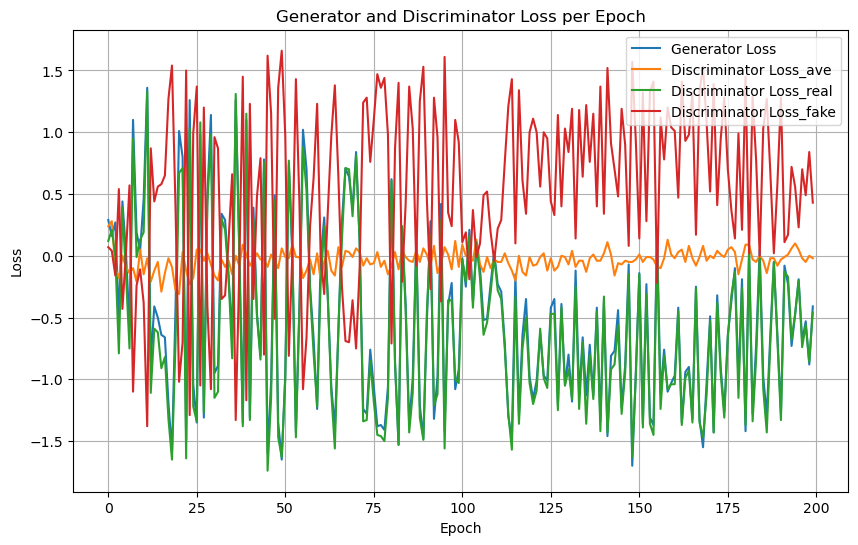

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # set the size of the figure

sns.lineplot(data=df, x=df.index, y='Generator Loss', label='Generator Loss')
sns.lineplot(data=df, x=df.index, y='Discriminator Loss_average', label='Discriminator Loss_ave')
sns.lineplot(data=df, x=df.index, y='Discriminator Loss_real', label='Discriminator Loss_real')
sns.lineplot(data=df, x=df.index, y='Discriminator Loss_fake', label='Discriminator Loss_fake')

plt.grid(True)  # add a grid

#plt.ylim(-1., 1.)  # set the y-axis limits
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss per Epoch')
plt.show()

In [4]:
import pickle
with open('../DATA/ctbank2_vis.pickle', 'rb') as f:
    loaded_list_of_dicts = pickle.load(f)

In [5]:
def find_indices(lst, key, value):
    return [i for i, dic in enumerate(lst) if dic.get(key) == value]

account_id = 200
indices = find_indices(loaded_list_of_dicts, 'account_id', account_id)

In [6]:
raw = real[['account_id', 'type', 'amount', 'tcode', 'datetime', 'year', 'month', 'dow', 'day', 'dtme','td']]

get_dtme = lambda d: calendar.monthrange(d.year, d.month)[1] - d.day

START_DATE = raw['datetime'].min()
MAX_YEARS_SPAN = 15
END_DATE = START_DATE.replace(year = START_DATE.year+ MAX_YEARS_SPAN)

ALL_DATES = [START_DATE + datetime.timedelta(i) for i in range((END_DATE - START_DATE).days)]

#AD = np.array([(d.month % 12, d.day % 31, d.weekday() % 7, i, d.year, get_dtme(d)) for i, d in enumerate(ALL_DATES)])
AD = np.array([(d.month -1, d.day -1, d.weekday() -1, i, d.year, get_dtme(d)) for i, d in enumerate(ALL_DATES)])

In [7]:
loaded_list_of_dicts[0].keys()

dict_keys(['day_ps', 'dtme_ps', 'dow_ps', 'month_ps', 'td_ps', 'account_id', 'si', 'timesteps'])

In [ ]:
import matplotlib.pyplot as plt
max_days = 100
for i in indices[:10]:
    si = loaded_list_of_dicts[i]['si']
    day_ps = np.array(loaded_list_of_dicts[i]['day_ps'])
    # Add more variables as needed
    dtme_ps = np.array(loaded_list_of_dicts[i]['dtme_ps'])
    dow_ps = np.array(loaded_list_of_dicts[i]['dow_ps'])
    month_ps = np.array(loaded_list_of_dicts[i]['month_ps'])
    td_ps = np.array(loaded_list_of_dicts[i]['td_ps'])
    account_id = loaded_list_of_dicts[i]['account_id']
    timesteps = loaded_list_of_dicts[i]['timesteps']
    print("*** Generating next date. Current Date is:", ALL_DATES[si], i)
    print("\n")

    fig, ax = plt.subplots(1,4, figsize=(20,4))
    ax[0].bar(np.arange(len(day_ps))+1, day_ps)
    ax[1].bar(np.arange(len(dtme_ps))+1, dtme_ps)
    ax[2].bar(np.arange(len(dow_ps))+1, dow_ps)
    ax[3].bar(np.arange(len(month_ps))+1, month_ps)

    for axi, lbl in enumerate(['DoM', 'DTME', 'DoW', 'Month']): 
        ax[axi].set_title(f"{lbl} ps")

    plt.tight_layout()
    plt.show()

    ######    Individual predictions - # days passed    ######
            
    fig, ax = plt.subplots(1,5, figsize=(20,4))

    ii = 0

    for lbl, vals in zip(['DoM', 'DTME', 'DoW', 'Month','Time_Delta'], 
                        [day_ps[AD[si:si+max_days,1]], dtme_ps[AD[si:si+max_days,-1]], dow_ps[AD[si:si+max_days,2]],month_ps[AD[si:si+max_days,0]], td_ps]):   

        ax[ii].set_xlabel("p(# days passed)")

        to_plot = vals/sum(vals)
        ax[ii].plot(to_plot)
        ax[ii].set_xlim([0, 31])
        ax[ii].set_ylim([0.0, np.max(to_plot)*1.05 ])
        ax[ii].set_title(f"p(# days passed| {lbl})")
        # ax[ii].set_xlabel("p(day until next)")

        # print("Len of", lbl, "is", len(vals))
        ii +=1

    plt.tight_layout()
    plt.show()


    ###########################################################################
    greedy_decode = True
    ps = month_ps[AD[si:si+max_days,0]]*day_ps[AD[si:si+max_days,1]]*dow_ps[AD[si:si+max_days,2]] *dtme_ps[AD[si:si+max_days,-1]] * td_ps
    if greedy_decode:
        timesteps1 = np.argmax(ps)
    else:
        timesteps1 = np.random.choice(max_days, p=ps/sum(ps))

    
    ######    Combined predictions - # days passed    ######


    fig, ax = plt.subplots(1,2, figsize=(20,4))

    ii = 0
    if sum(ps) == 0:
        ps = ps + 1e-10  # To prevent division by zero
    #ax[1].plot(ps/sum(ps))
    ax[1].plot(ps)
    ax[1].set_xlabel("p(# days passed)")

    ax[0].set_title(f"p(# days passed) - Each field")
    ax[1].set_title(f"p(# days passed) - Final")


    ax[1].plot(timesteps, ps[np.argmax(ps)], "*", label="choosen", markersize = 10)

    for lbl, vals in zip(['DoM', 'DTME', 'DoW', 'Month', "Time_delta"], 
                        [day_ps[AD[si:si+max_days,1]], dtme_ps[AD[si:si+max_days,-1]], dow_ps[AD[si:si+max_days,2]],month_ps[AD[si:si+max_days,0]],td_ps]):   
        
        ax[0].set_xlabel("p(# days passed)")
        ax[0].plot(vals/sum(vals), label=lbl)
        

        ii +=1

    ax[0].legend()
    ax[1].legend()
    # plt.legend
    plt.show()


In [9]:
loaded_list_of_dicts[0].keys()

dict_keys(['day_ps', 'dtme_ps', 'dow_ps', 'month_ps', 'td_ps', 'account_id', 'si', 'timesteps'])

In [7]:
len(loaded_list_of_dicts)

160000

In [54]:
all_synth_bf = pd.read_csv('../Banksformer/synth_banksformer_type1_clock.csv')
all_synth_lstm = pd.read_csv('../lstmModel/synth_lstm_type1_clock.csv')
all_synth_gan = pd.read_csv('../DATA/synth_ctgan_type1_clock_trans.csv')
all_real = real.copy()

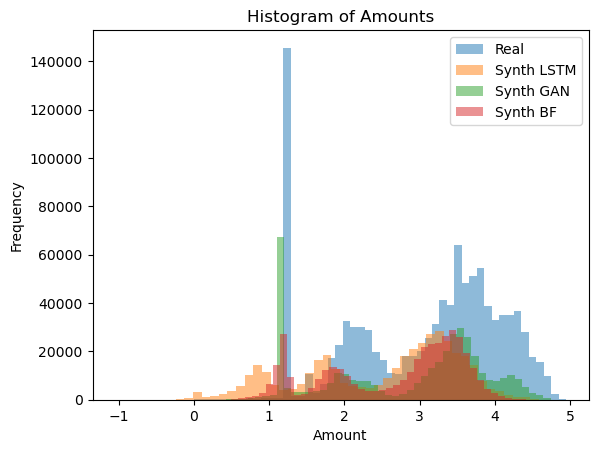

In [59]:
# Extract the 'amount' column from each dataset
amount_synth_bf = np.log10(all_synth_bf['amount'] + 1)
amount_synth_lstm = np.log10(all_synth_lstm['amount']+ 1)
amount_real = np.log10(all_real['amount']+ 1)
all_synth_gan['amount'] = all_synth_gan['log_amount_sc'] 
amount_synth_gan = np.log10(all_synth_gan['amount']+ 1)

# Plot histograms
plt.hist(amount_real, bins=50, alpha=0.5, label='Real')

plt.hist(amount_synth_lstm, bins=50, alpha=0.5, label='Synth LSTM')
plt.hist(amount_synth_gan, bins=50, alpha=0.5, label='Synth GAN')
plt.hist(amount_synth_bf, bins=50, alpha=0.5, label='Synth BF')


plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of Amounts')
plt.show()

In [67]:
all_synth_gan.columns

Index(['log_amount_sc', 'tcode', 'td', 'date', 'account_id', 'amount'], dtype='object')

In [72]:
all_synth_gan

,log_amount_sc,tcode,td,date,account_id,amount
0,14.37,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,0.959976,1996-12-13,0,14.37
1,18940.82,DEBIT__CASH WITHDRAWAL__nan,-0.023395,1996-12-19,0,18940.82
2,24364.50,DEBIT__CASH WITHDRAWAL__nan,1.511882,1996-12-20,0,24364.50
3,1449.04,DEBIT__CASH WITHDRAWAL__,6.599713,1997-01-07,0,1449.04
4,4119.75,DEBIT__CASH WITHDRAWAL__nan,0.679299,1997-01-08,0,4119.75
...,...,...,...,...,...,...
399995,5171.54,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1.650639,1997-03-09,4999,5171.54
399996,2929.86,DEBIT__REMITTANCE TO ANOTHER BANK__,1.581585,1997-03-09,4999,2929.86
399997,4250.03,CREDIT__COLLECTION FROM ANOTHER BANK__nan,2.933901,1997-03-12,4999,4250.03
399998,17415.67,DEBIT__CASH WITHDRAWAL__nan,6.215323,1997-03-14,4999,17415.67


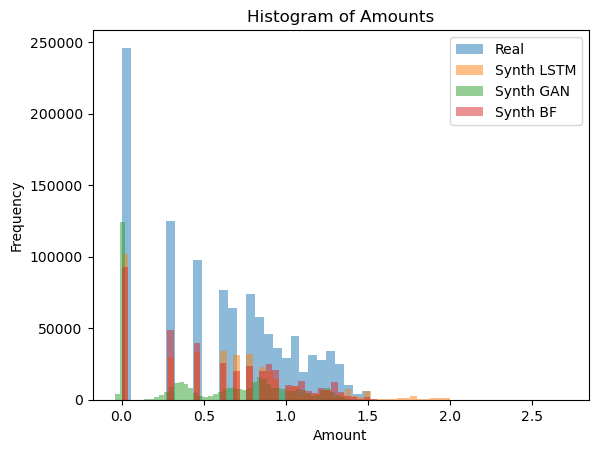

In [69]:
# Extract the 'amount' column from each dataset
amount_synth_bf = np.log10(all_synth_bf['days_passed'] +1) 
amount_synth_lstm = np.log10(all_synth_lstm['days_passed'] +1)
amount_real = np.log10(all_real['td_new'] +1)
#all_synth_gan['amount'] = all_synth_gan['log_amount_sc'] 
amount_synth_gan = np.log10(all_synth_gan['td'] +1)

# Plot histograms
plt.hist(amount_real, bins=50, alpha=0.5, label='Real')

plt.hist(amount_synth_lstm, bins=50, alpha=0.5, label='Synth LSTM')
plt.hist(amount_synth_gan, bins=50, alpha=0.5, label='Synth GAN')
plt.hist(amount_synth_bf, bins=50, alpha=0.5, label='Synth BF')


plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of Amounts')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


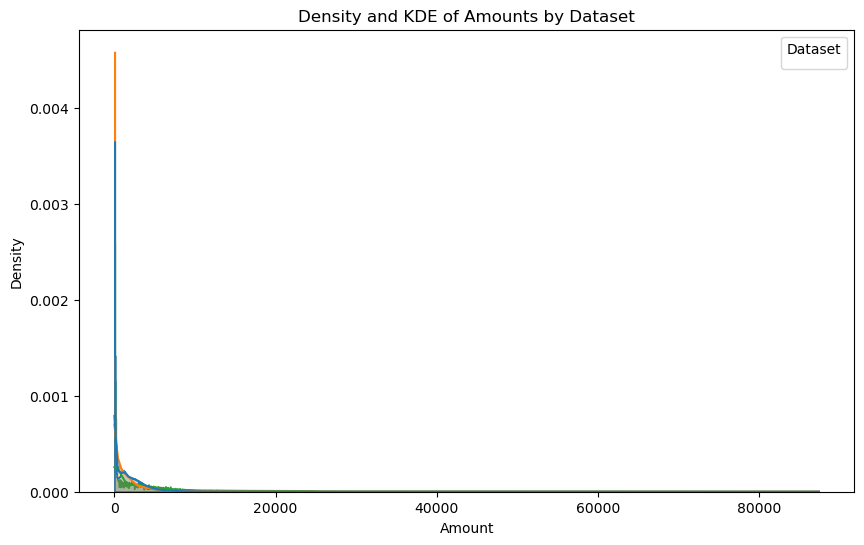

In [51]:
data = pd.concat([
    all_synth_bf['amount'].rename('Synth BF'),
    all_synth_lstm['amount'].rename('Synth LSTM'),
    all_real['amount'].rename('Real')
], axis=1)

# Melt the data for easier plotting with Seaborn
data_melted = data.melt(var_name='Dataset', value_name='Amount')

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(data=data_melted, x='Amount', hue='Dataset', element='step', kde=True, stat='density', common_norm=False)

plt.title('Density and KDE of Amounts by Dataset')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.legend(title='Dataset')
plt.show()